In [5]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline



In [9]:
import string

#brown corpus contains punctuations
#splitting the dataset by spaces yield words like "committee,"
#maketrans helps to separate this into two different words "committee" and ","

punc_dict = {p: " "+p+" " for p in string.punctuation}
punc_translation = str.maketrans(punc_dict)


In [10]:
# dataset
sentences = open("brown.txt").readlines()
print(f"{len(sentences)} sentences")

19810 sentences


In [11]:
def separate_punctuation(sentences):
    ret = [''] * len(sentences)
    for i, sentence in enumerate(sentences):
        translated_sentence = sentence.translate(punc_translation)
        ret[i]=translated_sentence
    
    return ret

def build_words(sentences):
    words_dict = {}
    for sentence in sentences:
        for w in sentence.split(" "):
            if w == '':
                continue
            words_dict[w] = words_dict.get(w, 0) + 1
    return words_dict

def get_words(words_dict):
    return words_dict.keys()

def map_rare_words(sentences, words_dict, freq_thresh=3, symbol="<UNK>"):
    ret = [''] * len(sentences)
    for i, sentence in enumerate(sentences):
        w = sentence.split(" ")
        for j, word in enumerate(w):
            if word == "":
                continue
            count = words_dict[word]
            if count <= 3:
                w[j] = symbol

        ret[i] = " ".join(w) 
    return ret 

def filter_empty_str (s):
    return list(filter(lambda ch:  ch != '' , s.split(" ")))

In [12]:
sentences_transformed = separate_punctuation(sentences)
word_dict = build_words(sentences_transformed)
words = get_words(word_dict)
sentences_transformed = map_rare_words(sentences_transformed, word_dict)
word_dict2 = build_words(sentences_transformed)
words2 = get_words(word_dict2)

In *A Neural Probabilistic Language Model by Bengio, et al.* their dataset contains:

* The number of different words is *47,578*.
* Reduced vocabulary of *16,383*.

In [14]:
print(f"Different words {len(words):,.0f}")
print(f"Reduced vocabulary  {len(words2):,.0f}")

Different words 51,103
Reduced vocabulary  17,797


My dataset contains about 4,000 more words and my reduced vocabulary of infrequent words is about 1,400 bigger. 

I don't think this would affect the final results in a significant manner.

In [15]:
# build the vocabulary of characters and mappings to/from integers
stoi = {s:i for i,s in enumerate(set(words2))}
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)

17797


In [16]:
import torch
# splitting the dataset into train, dev and test
# use 80% train - 10% dev - 10% test
#  
block_size = 5 # context length: how many characters do we take to predict the next one?

def build_dataset(sentences):  
    X, Y = [], []
  
    for sentence in sentences:
        words = filter_empty_str(sentence)
        context = [stoi[w] for w in words[:block_size] ]
        for word in words[block_size:] :
            if word == '':
                continue
            ix = stoi[word]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(sentences_transformed)
n1 = int(len(sentences_transformed) *0.8)
n2 = int(len(sentences_transformed) * 0.9) 

Xtr,  Ytr  = build_dataset(sentences_transformed[:n1])     
Xdev, Ydev = build_dataset(sentences_transformed[n1:n2])   
Xte,  Yte  = build_dataset(sentences_transformed[n2:])    

torch.Size([934453, 5]) torch.Size([934453])
torch.Size([114917, 5]) torch.Size([114917])
torch.Size([116012, 5]) torch.Size([116012])


In [17]:
# Printing training example with label
print(Xtr[0])
print(Ytr[0])

print(list(map(lambda x: itos[x.item()], Xtr[0])))
print(itos[Ytr[0].item()])

tensor([14732, 15795,   777,  1394,  9678])
tensor(9228)
['She', 'had', 'reason', 'indeed', 'to']
wonder


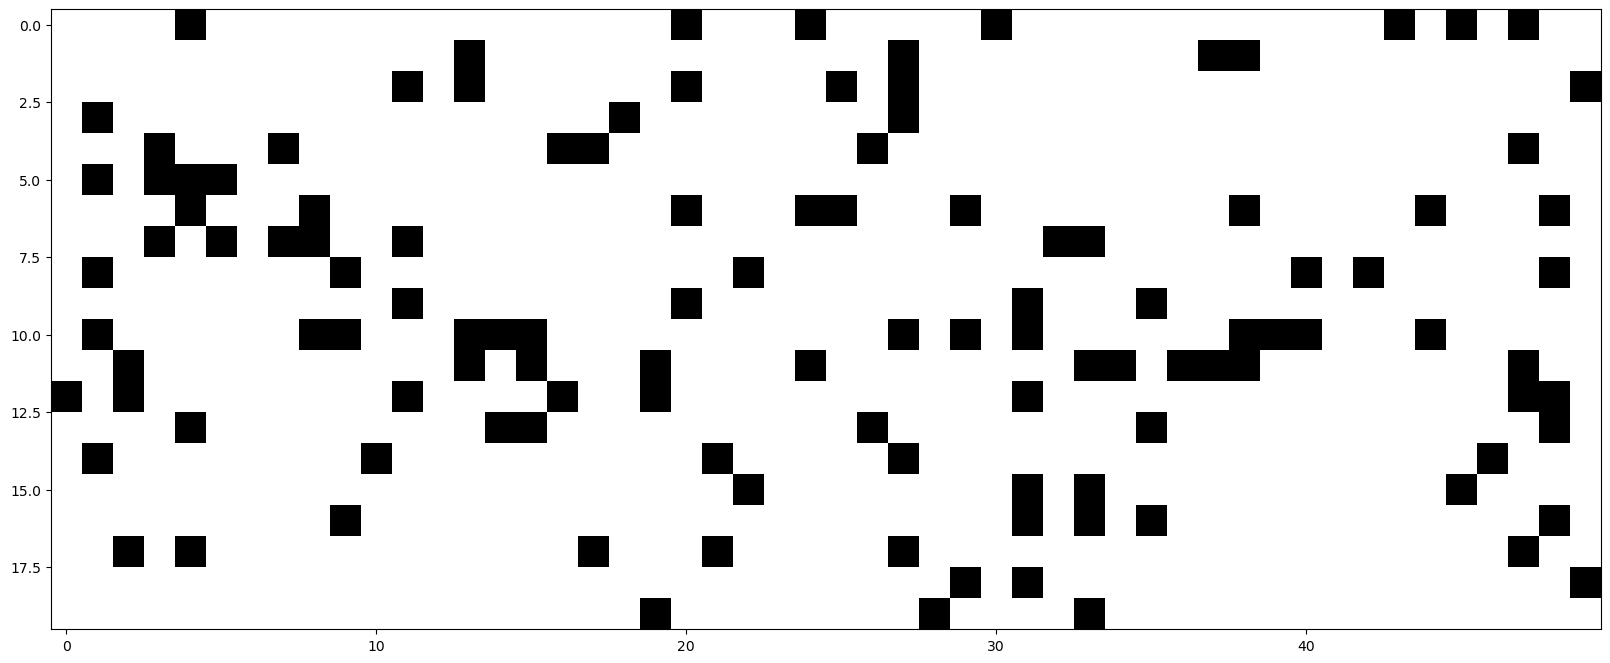

In [25]:
# Looking at activations results of the first Layer

from torch import nn
n_size = 5
emb_size = 60
h_size = 50
C = nn.Embedding(vocab_size, emb_size).type(torch.float32)
H = nn.Parameter(torch.randn((n_size)*emb_size, h_size).type(torch.float32))
d = nn.Parameter(torch.randn(h_size).type(torch.float32))
tanh = torch.tanh(C(Xtr).view(Xtr.shape[0], -1) @ H + d)
 
hist = tanh[:20,:].abs() > 0.99
plt.figure(figsize=(20,60))
plt.imshow(hist, cmap="gray", interpolation="nearest")

lots of white colums means that the weights going into the tanh are big enough that its outputs are being squeeze around 0.99 and 1, this makes the gradient very close to 1 making the backprop updates meaningless.

in NLPM2 model, I opted to include kaiming initializer to improve the initialization and the output of tanh at the start of the model

In [60]:
from torch import nn
class NLPM(nn.Module):
    def __init__(self, vocab_size, n_size=5, h_size=50, emb_size=60):
        super(NLPM, self).__init__()
        self.C = nn.Embedding(vocab_size, emb_size).type(torch.float32)
        self.H = nn.Parameter(torch.randn((n_size)*emb_size, h_size).type(torch.float32))
        torch.nn.functional.normalize(input, p=2.0, dim=1, eps=1e-12, out=None)
        nn.init.kaiming_uniform_(self.H, mode='fan_in', nonlinearity='tanh')
        self.d = nn.Parameter(torch.randn(h_size).type(torch.float32))
        self.W = nn.Parameter(torch.randn((n_size)*emb_size, vocab_size).type(torch.float32)*0.01)
        self.U = nn.Parameter(torch.randn(h_size, vocab_size).type(torch.float32) * 0.01)
        self.b = nn.Parameter(torch.randn(vocab_size).type(torch.float32))
    def forward(self, x):
        x = self.C(x)
        x = x.view(x.shape[0],-1)
        tanh = torch.tanh(x @ self.H + self.d)
        x = tanh @ self.U + x @ self.W  + self.b
        return x

In [165]:
model = NLPM(vocab_size)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=3e-5)

torch.Size([20, 50])


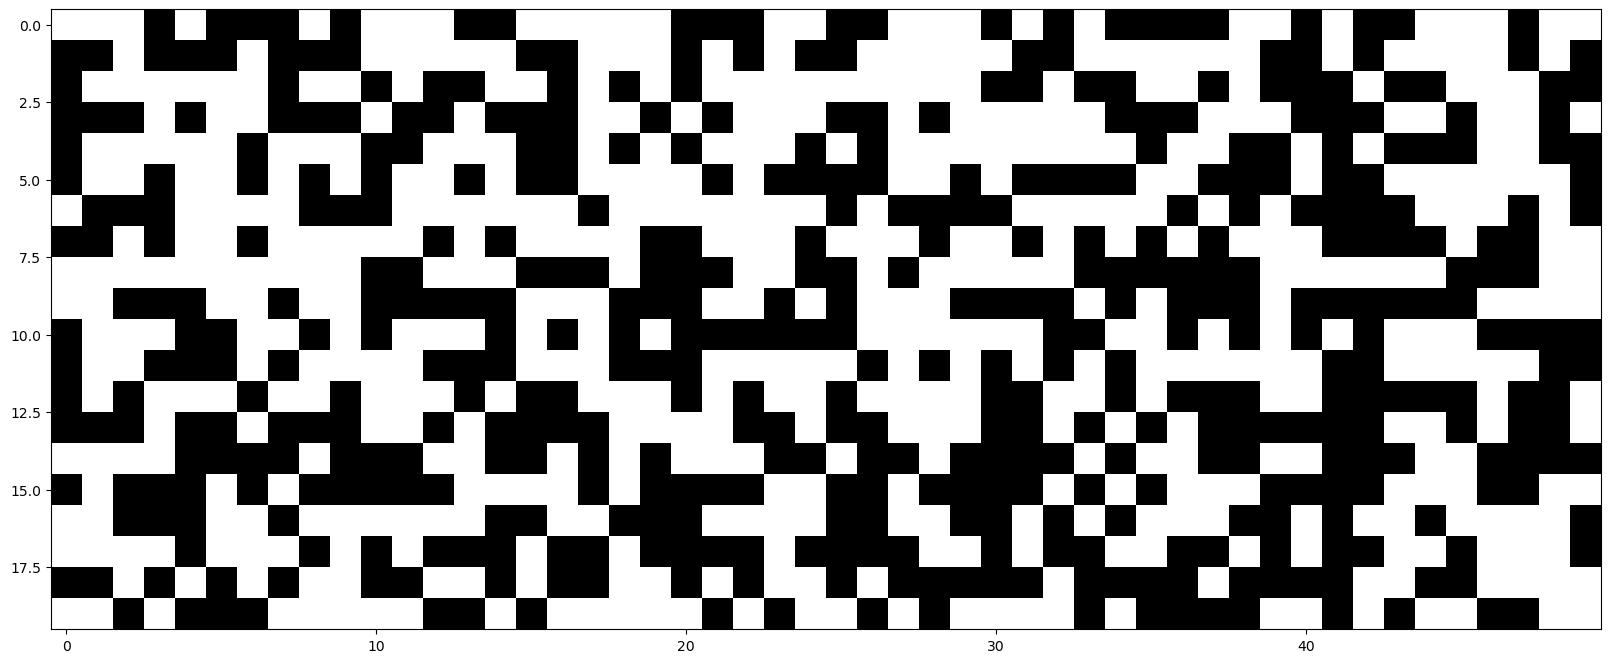

In [62]:
# initializing the weights with kaiming the activations look more descent and not white columns are detected
model.cpu()
h = torch.tanh(model.C(Xtr).view(Xtr.shape[0], -1) @ model.H + model.d)
t = h[:20,:].abs() > 0.99
print(t.shape)
plt.figure(figsize=(20,60))
plt.imshow(t, cmap="gray", interpolation="nearest")

In [166]:


lossi = []
n_updates = 0

In [171]:
max_steps = 32000
batch_size = 64
model.cuda()

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    optimizer.zero_grad()
    logits = model(Xtr[ix].cuda())
    loss = loss_fn(logits, Ytr[ix].cuda())
    loss.backward()
    optimizer.step()
    n_updates += 1
    #scheduler function to decrease learning rate as in the paper
    optimizer.param_groups[0]['lr'] /=  1 + 10**-8 * n_updates

    lossi.append(loss.item())
    if i % 1000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

      0/  32000: 5.1680
   1000/  32000: 4.4105
   2000/  32000: 5.0222
   3000/  32000: 4.7109
   4000/  32000: 5.5858
   5000/  32000: 5.3116
   6000/  32000: 4.8570
   7000/  32000: 4.7212
   8000/  32000: 4.7798
   9000/  32000: 5.5926
  10000/  32000: 4.7891
  11000/  32000: 4.9542
  12000/  32000: 5.3569
  13000/  32000: 5.7925
  14000/  32000: 4.8941
  15000/  32000: 5.5963
  16000/  32000: 5.1266
  17000/  32000: 4.6752
  18000/  32000: 5.4174
  19000/  32000: 4.9760
  20000/  32000: 5.2827
  21000/  32000: 4.7344
  22000/  32000: 4.8946
  23000/  32000: 5.3689
  24000/  32000: 4.7637
  25000/  32000: 4.5756
  26000/  32000: 5.6800
  27000/  32000: 4.8306
  28000/  32000: 5.0127
  29000/  32000: 5.0328
  30000/  32000: 5.5675
  31000/  32000: 5.3180


In [132]:

optimizer.param_groups[0]['lr']

5.978330512933091e-06

In [99]:
def perplexity(loss):
    return torch.exp(loss)

In [172]:
perplexity(torch.tensor(sum(lossi)/len(lossi)))

tensor(197.3096)

In [155]:
def test(model, X, Y, batch_size=64):
    ix = torch.randint(0, X.shape[0], (batch_size,))
    losses = []
    model.eval()
    with torch.no_grad():
        logits = model(X[ix].cuda())
        loss = loss_fn(logits, Y[ix].cuda())
        losses.append(loss.item())
    return losses
                


In [173]:
lossdev = torch.tensor([test(model, Xdev, Ydev) for i in range(n_updates)])


In [176]:
print("loss: ", lossdev.mean())
print("perplexity: ", torch.exp(lossdev.mean()))

loss:  tensor(5.5600)
perplexity:  tensor(259.8132)


In [177]:
losstest = torch.tensor([test(model, Xte, Yte) for i in range(n_updates)])

In [178]:
print("loss: ", losstest.mean())
print("perplexity: ", torch.exp(losstest.mean()))

loss:  tensor(5.5777)
perplexity:  tensor(264.4547)


In [179]:
# sample from the model

for _ in range(20):
    
    out = []
    context = [0] * 5 # initialize with all ...
    while True:
      x = torch.tensor(context).unsqueeze(0).cuda() # (1,block_size,d)
      logits = model(x) 
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    

In [180]:
print(' '.join(itos[i] for i in out))

State marry foresight , except from this powerful Chinese sitting , shall be in the self of <UNK> <UNK> in years ; there are many Kansas looking of their nature of , for his equipment . 
 the moment doses in an initial Ohio patches backed - jet al will war properly moving on the left on the Warwick and I asked him , through <UNK> columns , one drew may have been tune into a section conference , Jerry " ( you hurt ) Billy to McFeeley on size , that cash , , consumers upon asked , the rain has been exist with a relaxation Thor like her issues with a few whose affords using and white their Daniel Charley . The man set in the network of adjusted intervention . The picture , and the results of doing <UNK> replaced the Boys of his examination in place <UNK> the door conductivity in the wall - of <UNK> on the job infinite made during at cumulative - thereof , and I scraping albumin on <UNK> a window basis and destroyed daily <UNK> deceased Episcopal sales diamond by Atlanta the amount of demo